<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:28%">Importing the Required Libraries</b>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso,Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:28%">Reading the Train dataset</b>
</div>

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e17/train.csv')

train.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:28%">Checking the Categorical Columns</b>
</div>

In [4]:
train.Type.value_counts()

L    95354
M    32152
H     8923
Name: Type, dtype: int64

### There is only 1 categorical column 'Type' and it has 3 unique values ['L','M','H']

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:28%">Checking for any NaN data</b>
</div>

In [5]:
train.isna().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

### There is no NaN data, So we can proceed with Preprocessing

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:5%">Visualizing the correlation between columns before Preprocessing</b>
</div>

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'Air temperature [K]'}>,
        <Axes: title={'center': 'Process temperature [K]'}>],
       [<Axes: title={'center': 'Rotational speed [rpm]'}>,
        <Axes: title={'center': 'Torque [Nm]'}>,
        <Axes: title={'center': 'Tool wear [min]'}>],
       [<Axes: title={'center': 'Machine failure'}>,
        <Axes: title={'center': 'TWF'}>, <Axes: title={'center': 'HDF'}>],
       [<Axes: title={'center': 'PWF'}>, <Axes: title={'center': 'OSF'}>,
        <Axes: title={'center': 'RNF'}>]], dtype=object)

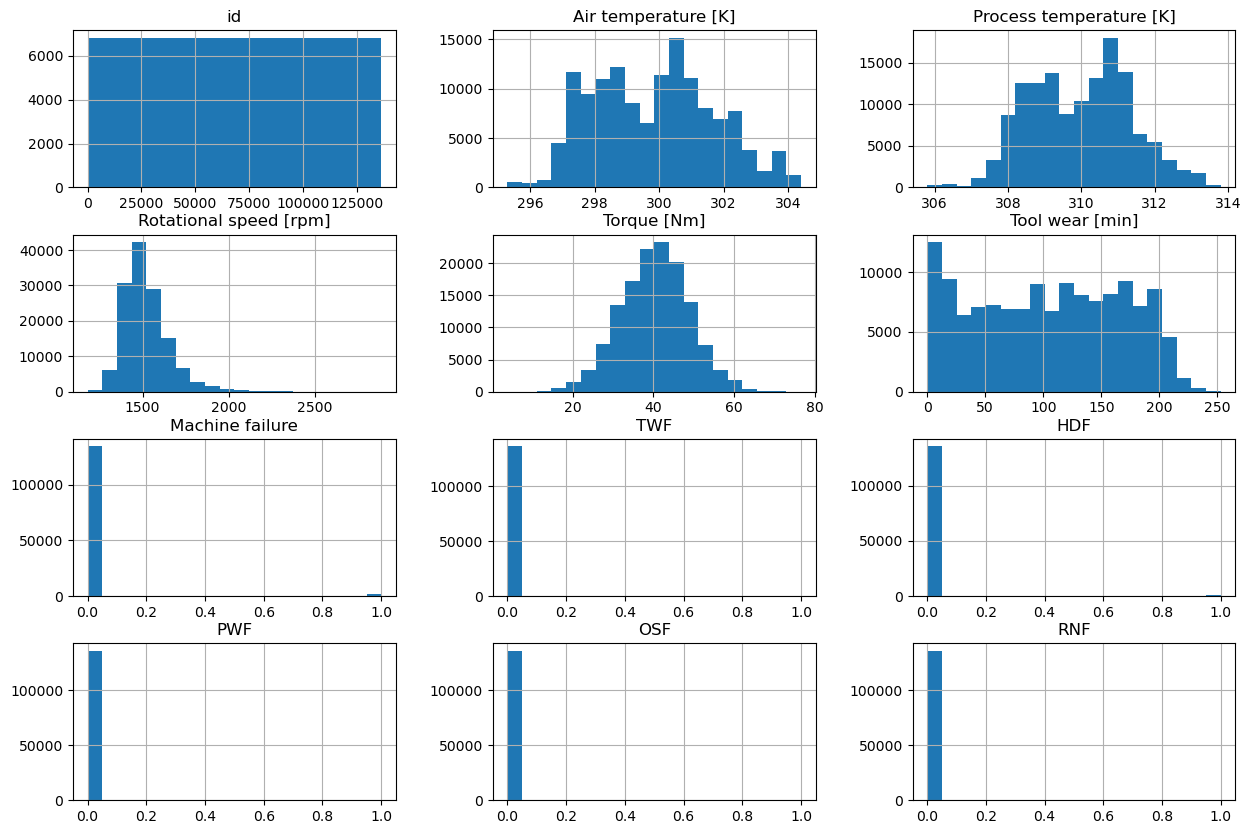

In [6]:
train.hist(bins=20, figsize=(15,10))

<Axes: >

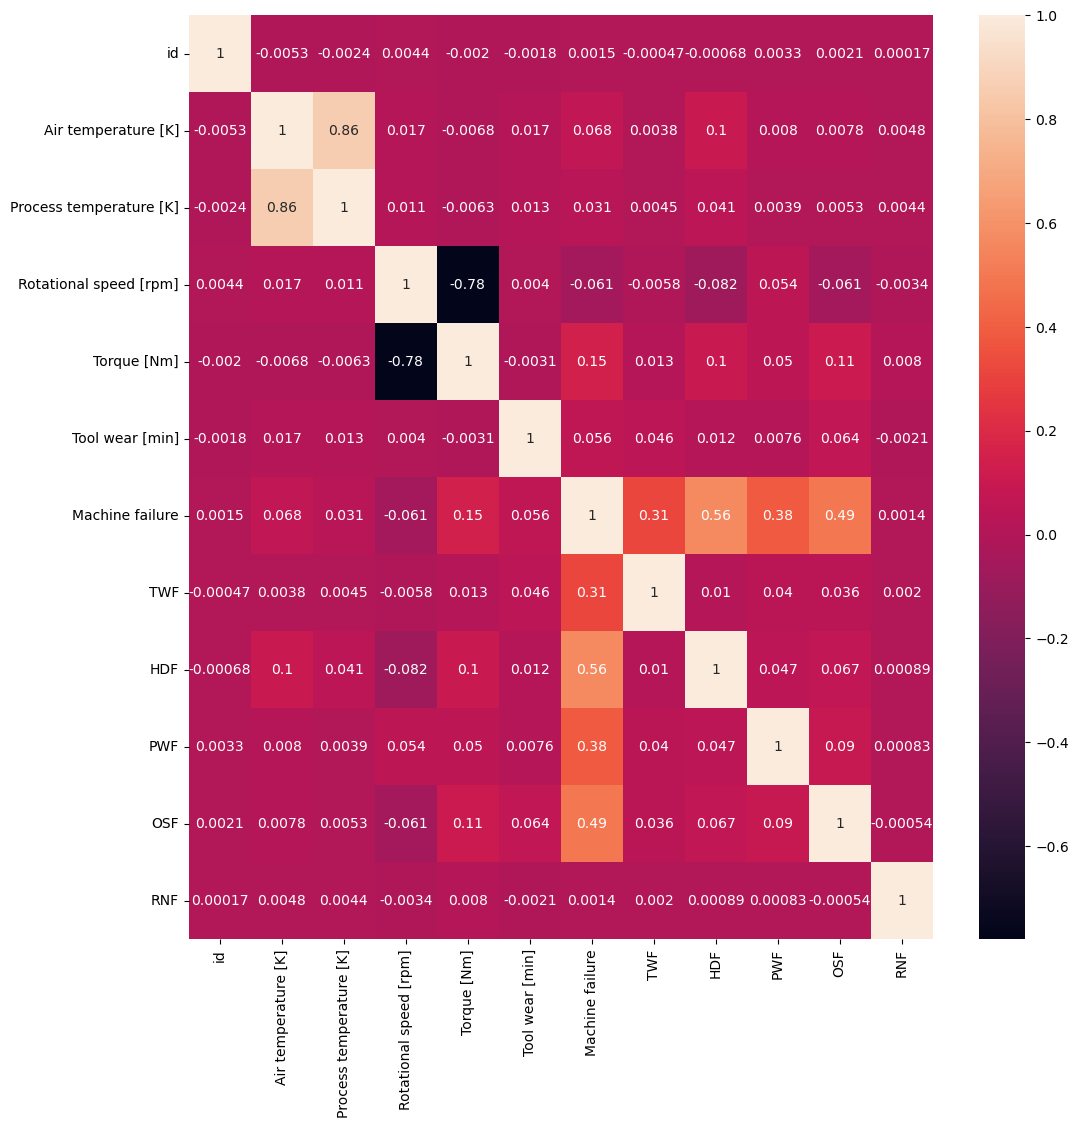

In [7]:
plt.rcParams['figure.figsize'] = [12,12]
sns.heatmap(train.corr(),annot=True)

### We can see that, the columns ['Torque', 'Rotational Speed'] are negatively correlated. This is because we have a Formula **P=τ*ω**

### And also the columns ['Air Temperature', 'Process Temperature'] are positively correlated. As both signify temperature.

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:22%">Function for Preprocessing the Data</b>
</div>

## - We use LabelEncoder to encode the Categorical columns ['Type']
## - We drop the 'id' and 'Product ID' columns, As they are unique and has nothing to do with machine functionality
## - We rename the columns which have units in their names
## - We use the **P=τ*ω** formula and create a new column named 'Power'
## - We use the columns ['Air Temperature', 'Process Temperature'] and create a new column containing their ratio
## - We drop the columns ['Torque', 'Rotational Speed', 'Air Temperature', 'Process Temperature']
## - return the resultant DataFrame

In [8]:
def preprocess(df):
  le = LabelEncoder()
  df['Type'] = le.fit_transform(df['Type'])
  df.drop(['id','Product ID'],axis=1,inplace=True)
  df.rename(columns={'Air temperature [K]':'Air temperature','Process temperature [K]':'Process temperature',
                     'Rotational speed [rpm]':'Rotational speed','Torque [Nm]':'Torque','Tool wear [min]':'Tool wear'},inplace=True)
  df['Power'] = df['Torque'] * df['Rotational speed']
  df['Temperature Ratio'] = df['Air temperature'] / df['Process temperature']
  df.drop(['Torque','Rotational speed','Air temperature','Process temperature'],axis=1,inplace=True)
  return df

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:27%">Preprocessing the Train Data</b>
</div>

In [9]:
train = preprocess(train)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:5%">Visualizing the Correlation between columns after Preprocessing</b>
</div>

<Axes: >

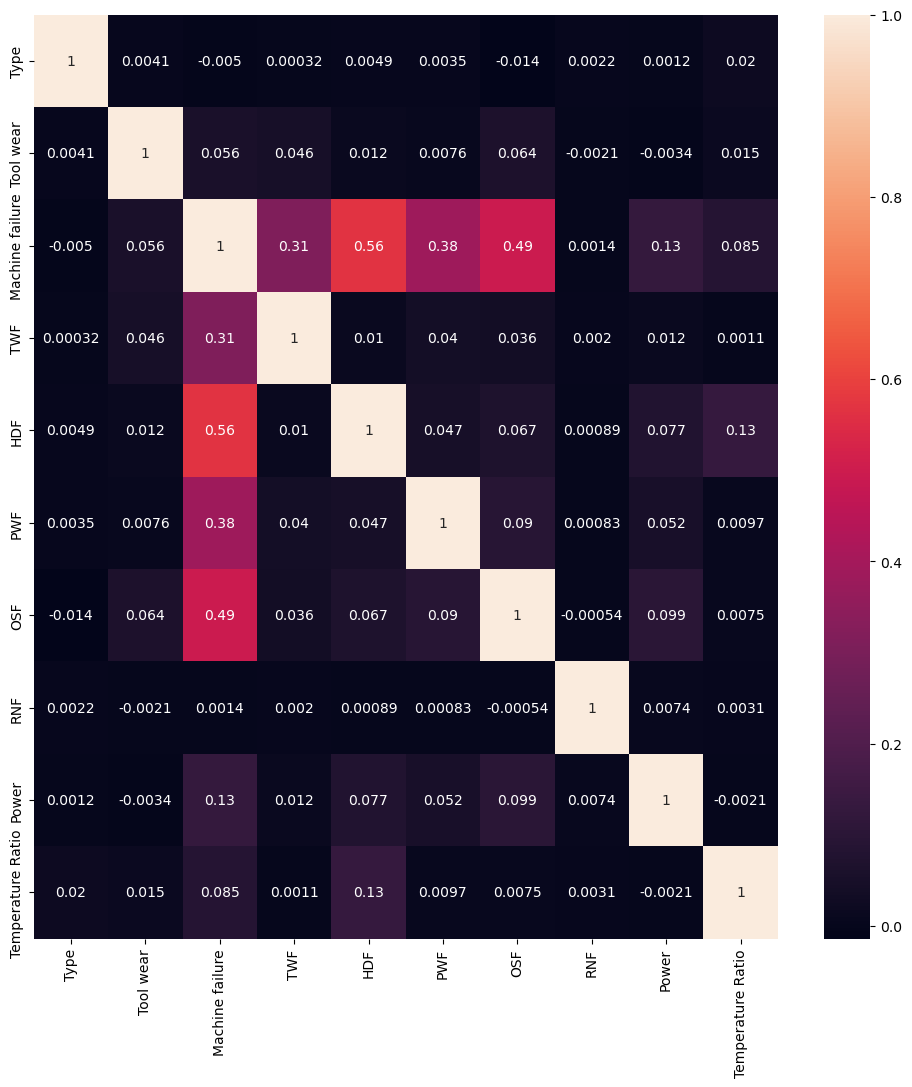

In [10]:
plt.rcParams['figure.figsize'] = [12,12]
sns.heatmap(train.corr(),annot=True)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:0%">Selecting the Features, Labels. And Splitting the Data into train and test data</b>
</div>

In [11]:
X = train[['Type', 'Tool wear', 'TWF', 'HDF', 'PWF', 'OSF','RNF', 'Power', 'Temperature Ratio']]
y = train[ 'Machine failure']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:18%">Creating an XGBoost Classifier and Training it</b>
</div>

In [12]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.02)
xgb.fit(X_train,y_train,early_stopping_rounds=25,eval_set=[(X_test,y_test)],verbose=75)

[0]	validation_0-rmse:0.49016
[75]	validation_0-rmse:0.12350
[150]	validation_0-rmse:0.06641
[225]	validation_0-rmse:0.06238
[286]	validation_0-rmse:0.06228


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:29%">Accuracy of our model</b>
</div>

In [13]:
print('Train score : ',xgb.score(X_train,y_train))
print('Test score : ',xgb.score(X_test,y_test))


Train score :  0.7764629742214615
Test score :  0.752994423259975


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:25%">Reading the Test Data for Prediction</b>
</div>

In [14]:
test = pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv')
testids = test['id']

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:29%">Preprocessing the test data</b>
</div>

In [15]:
test = preprocess(test)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:20%">Predicting the Machine Failure for Test data</b>
</div>

In [16]:
preds = xgb.predict(test)

In [17]:
preds

array([0.00405271, 0.00405271, 0.00405271, ..., 0.00405271, 0.00405271,
       0.00405271], dtype=float32)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:19%">Storing the Predictions in a Data Frame</b>
</div>

In [18]:
sub_df = pd.DataFrame({'id':testids,'Machine failure':preds})

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4605fa;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:9%">Exporting the DataFrame to a csv file and submitting it</b>
</div>

In [19]:
sub_df.to_csv('/kaggle/working/sub_df.csv',index=False)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#000;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;">
    <b style="text-align:center;padding-left:39%">Thank You</b>
</div>